In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('SampleSubmission.csv')

In [3]:
print(train.shape)
print(test.shape)

(30557, 82)
(16136, 77)


In [4]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [5]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [6]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
# train['year'] = train['Date'].dt.year
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear

test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
# test['year'] = test['Date'].dt.year
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear

In [7]:
to_remove = ["Place_ID X Date","Date","Place_ID","target","target_min","target_max","target_variance","target_count"]
train_copy=train.copy()
columns=train_copy.drop(to_remove,1).columns
train_copy=train_copy[columns]
km=KMeans(7,random_state=42)
km=km.fit(train_copy[columns])
train["cluster"]=km.predict(train[columns])
test["cluster"]=km.predict(test[columns])

In [8]:
# train['l3_NO2_densities'] = train['L3_NO2_NO2_column_number_density']+train['L3_NO2_NO2_slant_column_number_density']+train['L3_NO2_stratospheric_NO2_column_number_density']+train['L3_NO2_tropospheric_NO2_column_number_density']
# train['l3_HCHO_densities'] = train['L3_HCHO_HCHO_slant_column_number_density'] + train['L3_HCHO_tropospheric_HCHO_column_number_density'] + train['L3_HCHO_tropospheric_HCHO_column_number_density']

In [9]:
# test['l3_NO2_densities'] = test['L3_NO2_NO2_column_number_density']+test['L3_NO2_NO2_slant_column_number_density']+test['L3_NO2_stratospheric_NO2_column_number_density']+test['L3_NO2_tropospheric_NO2_column_number_density']
# test['l3_HCHO_densities'] = test['L3_HCHO_HCHO_slant_column_number_density'] + test['L3_HCHO_tropospheric_HCHO_column_number_density'] + test['L3_HCHO_tropospheric_HCHO_column_number_density']

In [10]:
#Frequency Encoding for Place_ID
freq_id_train = train.groupby('Place_ID').size()
freq_id_train = freq_id_train/len(train)
train['freq_id_train'] = train.Place_ID.map(freq_id_train)

freq_id_test = test.groupby('Place_ID').size()
freq_id_test = freq_id_test/len(test)
test['freq_id_test'] = test.Place_ID.map(freq_id_test)


In [11]:
#Frequency Encoding for Date
freq_date_train = train.groupby('Date').size()
freq_date_train = freq_date_train/len(train)
train['freq_date_train'] = train.Date.map(freq_date_train)

freq_date_test = test.groupby('Date').size()
freq_date_test = freq_date_test/len(test)
test['freq_date_test'] = test.Date.map(freq_date_test)

In [12]:
#Target_ Encoding
target_mean = train.groupby(['cluster']).mean()[['target']]
for i in list(target_mean.columns):
  target_mean.rename({i:i+"_mean"},axis=1,inplace=True)
train = train.merge(target_mean,how="left",on='cluster')
test = test.merge(target_mean,how="left",on='cluster')

In [13]:
# drop_col = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air','L3_CH4_aerosol_height','L3_CH4_aerosol_optical_depth',
# 'L3_CH4_sensor_azimuth_angle','L3_CH4_sensor_zenith_angle','L3_CH4_solar_azimuth_angle','L3_CH4_solar_zenith_angle']

In [14]:
train.drop(columns=['Place_ID X Date','Date','Place_ID','target_min','target_max','target_variance','target_count'], axis=1, inplace=True)
test.drop(columns=['Place_ID X Date','Date','Place_ID'], axis=1, inplace=True)

In [15]:
train['component_of_wind_uv'] = train['u_component_of_wind_10m_above_ground']+train['v_component_of_wind_10m_above_ground']
test['component_of_wind_uv'] = test['u_component_of_wind_10m_above_ground']+test['v_component_of_wind_10m_above_ground']

In [16]:
print(train.shape)
print(test.shape)

(30557, 84)
(16136, 83)


In [17]:
def metric(y,x):
    return np.sqrt(mean_squared_error(x,y))

In [18]:
X = train.drop('target',axis=1)
y = train.target

In [19]:
testsplit_store=[]
test_store=[]
fold=KFold(n_splits=15, shuffle=True, random_state=2020)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lgb = LGBMRegressor(n_estimators=10000,eval_metric='RMSE', learning_rate=0.0801032, random_seed= 2020, l2_leaf_reg=4, use_best_model=True)
    lgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300,verbose=100)
    predict = lgb.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
    pred = lgb.predict(test)
    test_store.append(pred)

Training until validation scores don't improve for 300 rounds
[100]	training's l2: 680.161	valid_1's l2: 838.738
[200]	training's l2: 520.791	valid_1's l2: 770.194
[300]	training's l2: 423.359	valid_1's l2: 737.425
[400]	training's l2: 350.293	valid_1's l2: 712.709
[500]	training's l2: 295.624	valid_1's l2: 688.536
[600]	training's l2: 253.621	valid_1's l2: 679.777
[700]	training's l2: 217.778	valid_1's l2: 664.822
[800]	training's l2: 191.148	valid_1's l2: 657.965
[900]	training's l2: 166.042	valid_1's l2: 650.619
[1000]	training's l2: 145.699	valid_1's l2: 644.894
[1100]	training's l2: 128.53	valid_1's l2: 639.471
[1200]	training's l2: 114.168	valid_1's l2: 635.557
[1300]	training's l2: 101.958	valid_1's l2: 632.284
[1400]	training's l2: 90.0185	valid_1's l2: 630.398
[1500]	training's l2: 79.7991	valid_1's l2: 626.764
[1600]	training's l2: 71.059	valid_1's l2: 624.742
[1700]	training's l2: 63.4136	valid_1's l2: 623.028
[1800]	training's l2: 56.5185	valid_1's l2: 621.553
[1900]	traini

In [20]:
#-999
np.mean(testsplit_store)

25.65006789622153

In [ ]:
#-999
np.mean(testsplit_store)
25.65006789622153

In [24]:
test_id = pd.read_csv('Test.csv')

In [25]:
sub=test_id[['Place_ID X Date']].copy() 
sub['target']= np.mean(test_store, 0)

In [26]:
sub.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,43.411451
1,0OS9LVX X 2020-01-03,36.221013
2,0OS9LVX X 2020-01-04,30.243213
3,0OS9LVX X 2020-01-05,28.259372
4,0OS9LVX X 2020-01-06,20.554611


In [27]:
sub.to_csv('lgb3.csv',index=False)

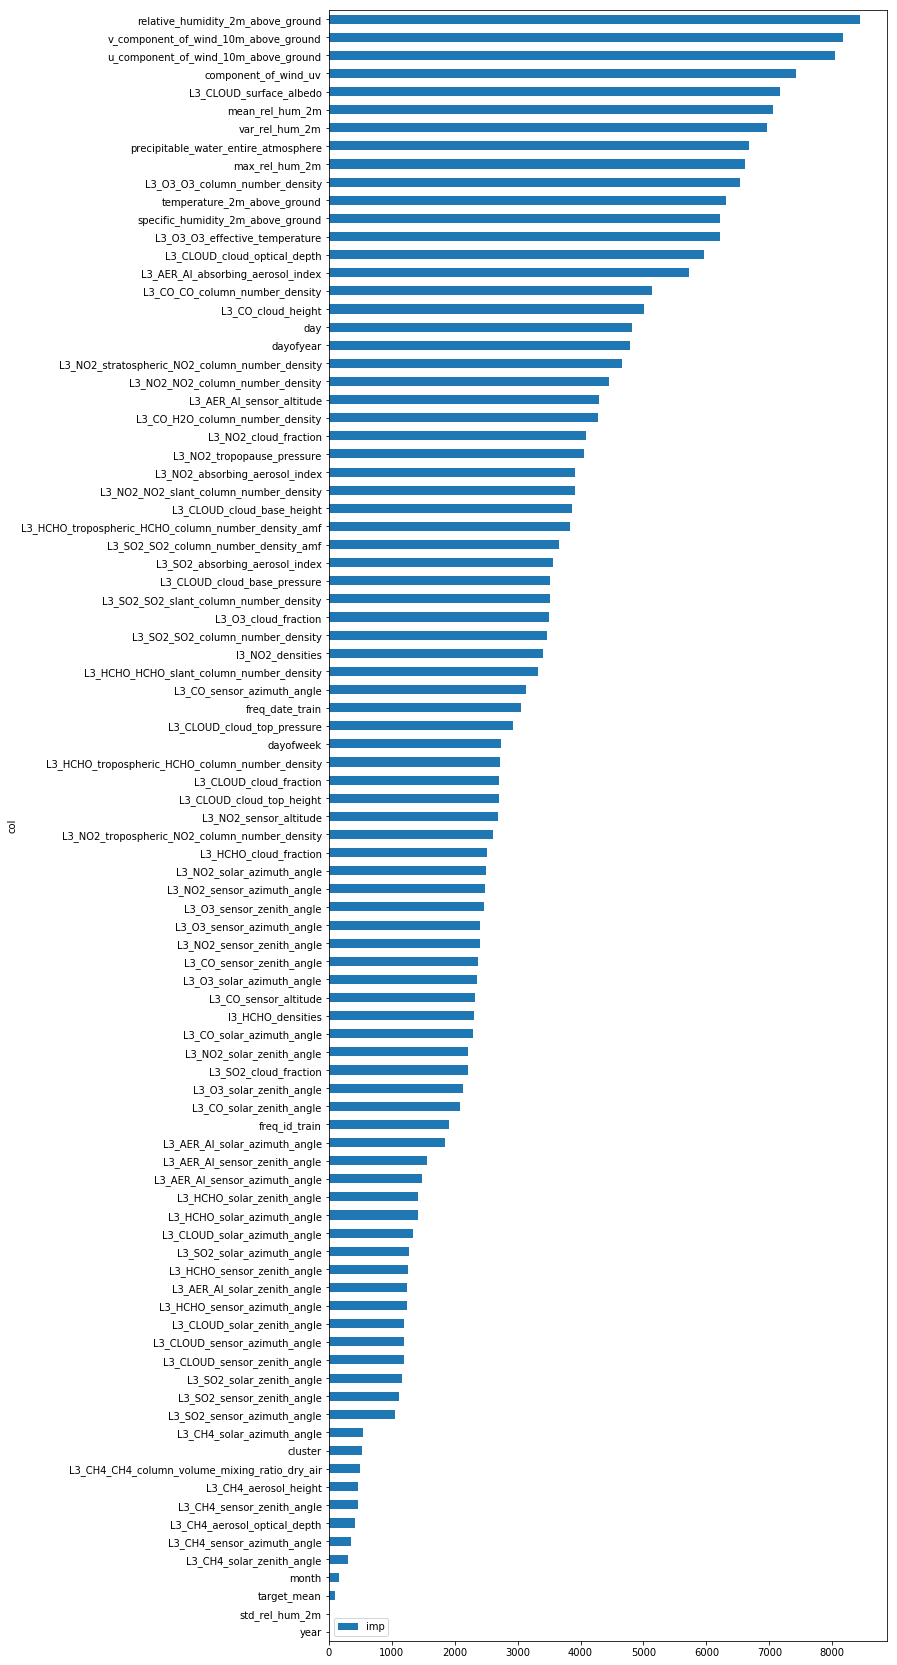

In [28]:
## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':lgb.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-90:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 30))
plt.savefig('catboost_feature_importance.png')
plt.show()